In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Barents = pd.read_excel(filepath, sheet_name='Barents-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Barents)
fp.date_time(Barents)

,Extent,Date
0,1107873.946,1979-01-01
1,1211101.473,1979-02-01
2,1215128.770,1979-03-01
3,1233940.811,1979-04-01
4,1193061.566,1979-05-01
...,...,...
533,124025.343,2023-06-01
534,53107.426,2023-07-01
535,11242.827,2023-08-01
536,3272.024,2023-09-01


In [5]:
scaler = MinMaxScaler()
Barents['Extent'] = scaler.fit_transform(Barents['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 3
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Barents['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((524, 12, 1), (524,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Barents_model_LT3/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 18s 212ms/step - loss: 0.1930 - root_mean_squared_error: 0.4394 - val_loss: 0.0529 - val_root_mean_squared_error: 0.2300
Epoch 2/50
53/53 [==============================] - 11s 212ms/step - loss: 0.1026 - root_mean_squared_error: 0.3204 - val_loss: 0.0397 - val_root_mean_squared_error: 0.1992
Epoch 3/50
53/53 [==============================] - 13s 255ms/step - loss: 0.0428 - root_mean_squared_error: 0.2068 - val_loss: 0.0304 - val_root_mean_squared_error: 0.1743
Epoch 4/50
53/53 [==============================] - 13s 241ms/step - loss: 0.0359 - root_mean_squared_error: 0.1896 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1553
Epoch 5/50
53/53 [==============================] - 13s 253ms/step - loss: 0.0310 - root_mean_squared_error: 0.1761 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1493
Epoch 6/50
53/53 [==============================] - 13s 248ms/step - loss: 0.0312 - root_mean_squared_error: 0.1767 - val_loss: 0.0202 

53/53 [==============================] - 1s 22ms/step - loss: 0.0165 - root_mean_squared_error: 0.1285 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1081
Epoch 27/50
53/53 [==============================] - 11s 206ms/step - loss: 0.0169 - root_mean_squared_error: 0.1300 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1057
Epoch 28/50
53/53 [==============================] - 12s 234ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1050
Epoch 29/50
53/53 [==============================] - 1s 27ms/step - loss: 0.0157 - root_mean_squared_error: 0.1252 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 30/50
53/53 [==============================] - 13s 249ms/step - loss: 0.0164 - root_mean_squared_error: 0.1282 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1045
Epoch 31/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0160 - root_mean_squared_error: 0.1267 - val_loss: 0.0109 - val_root_m

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

7.14136620759964 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

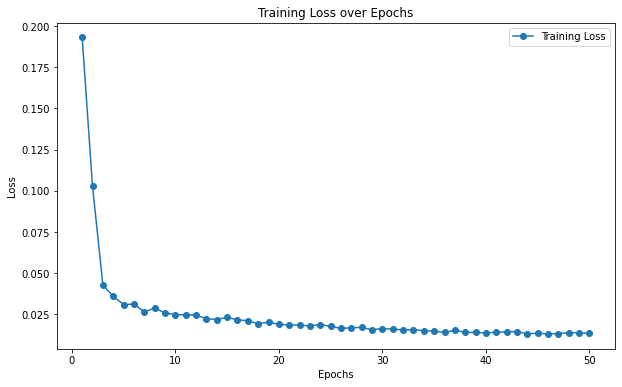

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

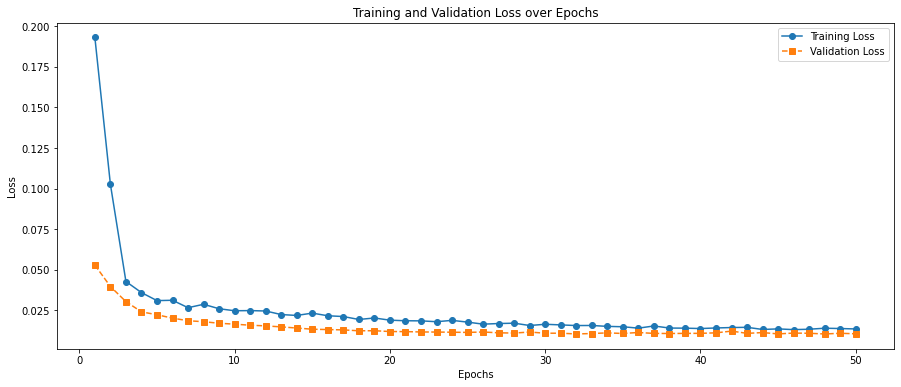

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Barents_model_LT3/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 15ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.09333775121015034
MAE : 0.07158046392703142


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,40407.593750,112300.019
1,-34861.386719,44787.893
2,-36329.304688,14909.156
3,8154.253906,54595.378
4,104323.351562,242829.930
5,250204.250000,406860.687
6,414332.562500,605897.837
7,541115.937500,654073.790
8,611679.187500,701143.910
9,580423.437500,657891.340


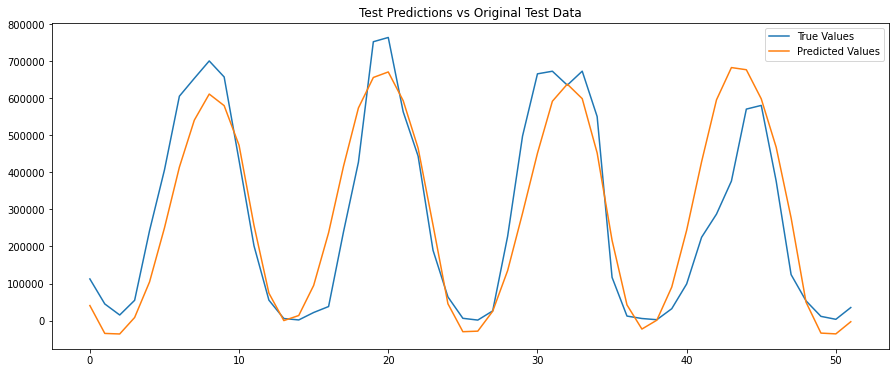

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 18ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

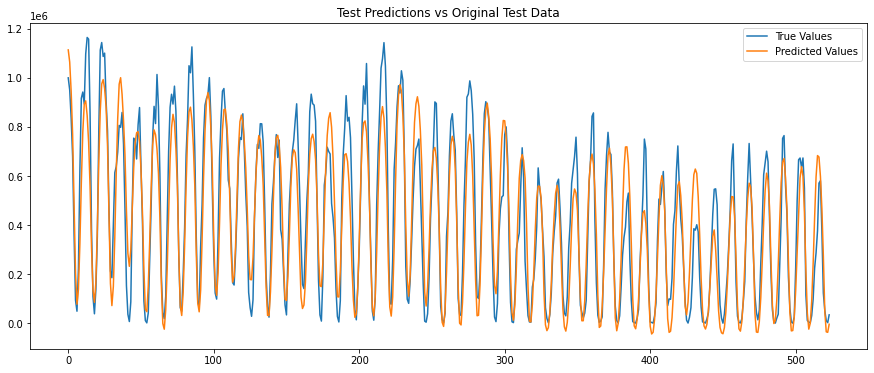

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()